# Libraries

In [1]:
import os
import glob
import math
from collections import defaultdict

from src.pipeline.dataloader import DataLoader
from src.pipeline.taskloader import TaskLoader, TaskFrame

from src.settings import Strategy

from src.models.linear import GLM

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

In [2]:
DataLoader.DATA_FOLDER = './data/'
dl = DataLoader()
tl = TaskLoader()

glm = GLM()

# Model building

In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer, ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.feature_selection import RFE

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, GammaRegressor

from sklearn.metrics import mean_absolute_error

In [18]:
def get_generator():
    df = dl.get_simple_protein_metabolite_dataframe()
    gen = tl.prepare_task(df).build(Strategy.METABOLITE_CENTRIC)
    return gen

def build_model_pipeline():
    tf = next(get_generator())

    numeric_features = ['enzyme_concentration']
    numeric_transformer = Pipeline(
        steps=[
            ('scaler', StandardScaler())
        ]
    )

    cat_features = ['KO_ORF', 'ORF']
    categorical_transformer = OneHotEncoder(
        categories=[
            tf.x.reset_index()['KO_ORF'].unique(),
            tf.x.reset_index()['ORF'].unique()
        ]
    )

    prepocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, cat_features),
        ]
    )

    estimator = DecisionTreeRegressor()

    clf = Pipeline(
        steps=[
            ('preprocessor', prepocessor),
            ('regressor', estimator),
        ]
    )

    model = TransformedTargetRegressor(
        regressor=clf,
        transformer=StandardScaler(),
    )
    return model

## Simple data model (Tier 1)

In [4]:
params = [{
    'regressor__regressor': [GammaRegressor()],
    'regressor__regressor__alpha': [0, 1, 10],
    'transformer': [MinMaxScaler()],
}, {
    'regressor__regressor': [DecisionTreeRegressor()],
    'regressor__regressor__criterion': ['squared_error', 'friedman_mse'],
    'regressor__regressor__max_depth': [None, 5, 10, 20, 15]
}, {
    'regressor__regressor': [SVR()],
    'regressor__regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}, {
    'regressor__regressor': [ElasticNet()],
    'regressor__regressor__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
}]

In [10]:
model = build_model_pipeline()
cv = RepeatedKFold(n_repeats=10, random_state=0)

In [ ]:
gen = get_generator()

for tf in gen:
    if not(os.path.exists(f'{tf.title}_{tf.frame_name}.csv')):
        print(f'Training: {tf.title}_{tf.frame_name}.csv')

        df = tf.x.reset_index()
        X_train, X_test, y_train, y_test = train_test_split(
            df,
            tf.y,
            test_size=0.2,
            random_state=0,
            shuffle=False
        )

        search = GridSearchCV(
            model,
            params,
            scoring='neg_mean_absolute_error',
            n_jobs=-1,
            refit=True,
            cv=cv,
            verbose=3,
        )
        search.fit(X_train, y_train)

        df = pd.DataFrame(search.cv_results_)
        df.to_csv(f'{tf.title}_{tf.frame_name}.csv')


print("model score: %.3f" % search.score(X_test, y_test))
mean_absolute_error(y_test, search.predict(X_test))

In [11]:
dir = "/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_simple_baseline"
paths = glob.glob(dir + "/*.csv")

metabolites_names = [path.rsplit('/', 1)[1].removesuffix('.csv').removeprefix('Strategy.METABOLITE_CENTRIC_') for path in paths]
results_df = pd.concat([
    pd.read_csv(path).assign(metabolite_id=metabolite_name) 
    for path, metabolite_name in zip(paths, metabolites_names)
])

In [ ]:
gen = get_generator()
best_models = results_df[results_df['rank_test_score'] == 1]
model = build_model_pipeline()
results = defaultdict(lambda: list())

for tf in gen:
    c_best_models = best_models[best_models['metabolite_id'] == tf.frame_name]

    model.regressor.set_params(
        regressor=DecisionTreeRegressor(),
        regressor__criterion=c_best_models['param_regressor__regressor__criterion'].values[0],
        regressor__max_depth=None if math.isnan(r := c_best_models['param_regressor__regressor__max_depth'].values[0]) else int(r)
    )
    
    df = tf.x.reset_index()
    X_train, X_test, y_train, y_test = train_test_split(
        df,
        tf.y,
        test_size=0.2,
        random_state=0,
        shuffle=False
    )

    for _ in range(100):
        model.fit(X_train, y_train)
        results[tf.frame_name].append(model.score(X_test, y_test))
        # print(model.score(X_test, y_test))
        
pd.DataFrame.from_dict(results).to_csv('./data/results/experiment_simple_baseline/best_model_performance.csv')

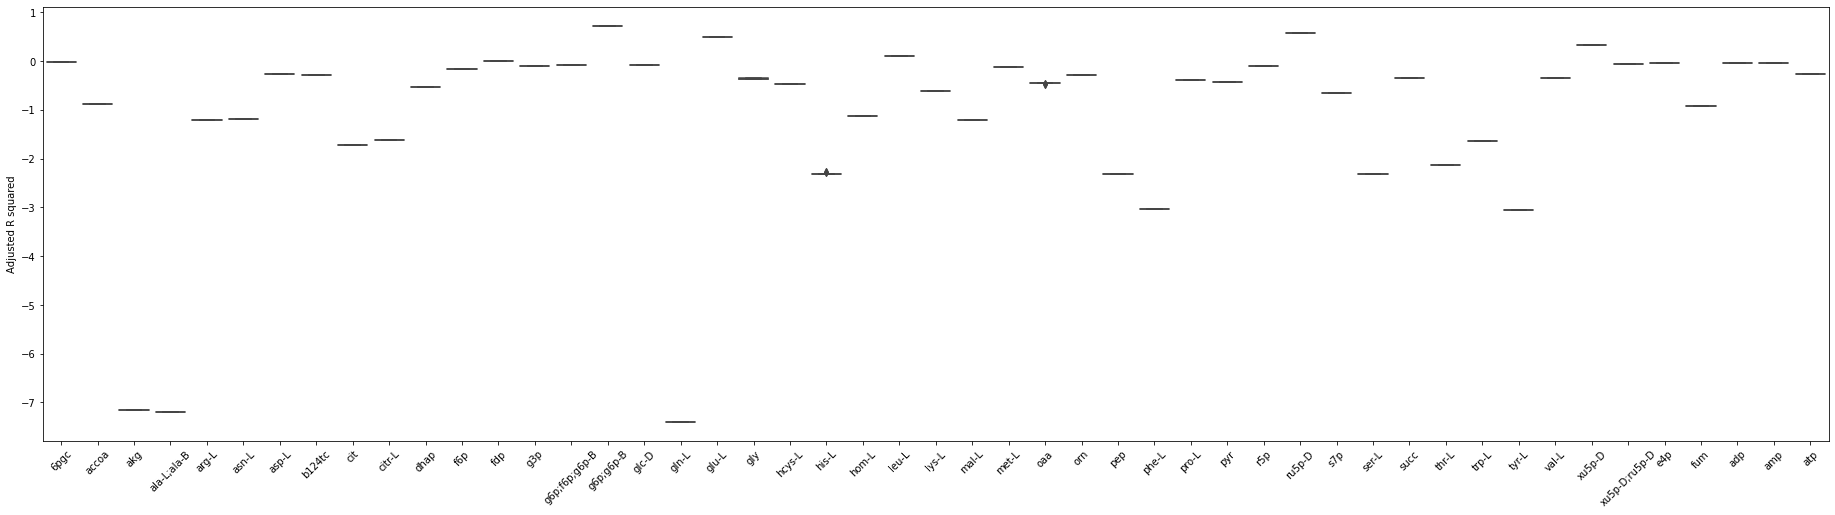

In [62]:
fig, ax = plt.subplots(figsize=(32,8))

chart = sns.boxplot(
    data=pd.DataFrame.from_dict(results)
)

chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
ax.set_ylabel('Adjusted R squared')
plt.show()

# ax.hlines(0)

In [46]:
results_df[['param_regressor__regressor', 'mean_test_score', 'rank_test_score', 'metabolite_id']].to_csv('test.csv')

In [42]:
best_models[['param_regressor__regressor', 'mean_test_score', 'rank_test_score']]

,param_regressor__regressor,mean_test_score,rank_test_score
11,DecisionTreeRegressor(criterion='friedman_mse'...,-1.078179e-15,1
12,DecisionTreeRegressor(criterion='friedman_mse'...,-1.056342e-14,1
8,DecisionTreeRegressor(criterion='friedman_mse'),-4.886121e-13,1
11,DecisionTreeRegressor(criterion='friedman_mse'...,-3.225679e-13,1
8,DecisionTreeRegressor(criterion='friedman_mse'),-1.780463e-15,1
8,DecisionTreeRegressor(criterion='friedman_mse'),-4.108152e-14,1
8,DecisionTreeRegressor(criterion='friedman_mse'),-2.363187e-13,1
11,DecisionTreeRegressor(criterion='friedman_mse'...,-5.360181e-14,1
8,DecisionTreeRegressor(criterion='friedman_mse'),-6.590745e-12,1
11,DecisionTreeRegressor(criterion='friedman_mse'...,-1.593692e-13,1


In [38]:
best_models = df[df['rank_test_score'] == 1]
best_models[['params', 'metabolite_id']]

KeyError: 'rank_test_score'

In [ ]:
dt: DecisionTreeRegressor = model.regressor.named_steps['select']
dt.n_features_

KeyError: 'select'

In [ ]:
len(set(y_train.unique()).difference(set(y_test.unique())))

76

<AxesSubplot:xlabel='enzyme_concentration', ylabel='Count'>

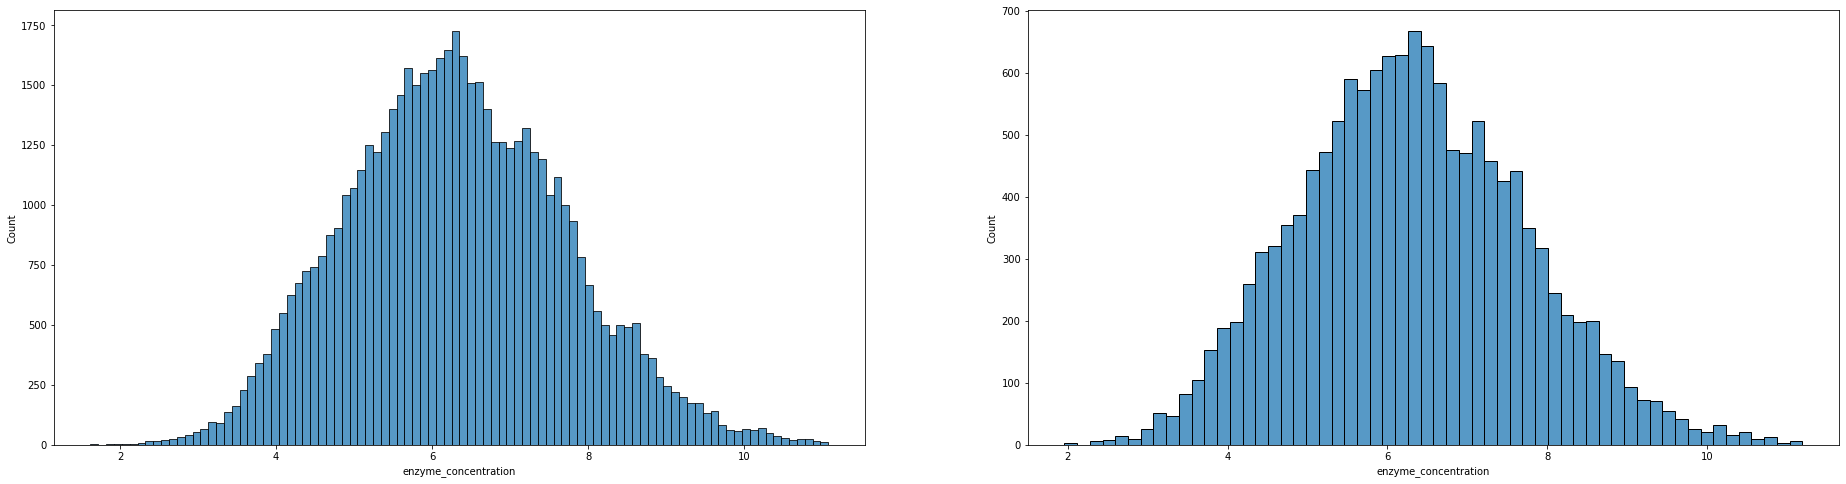

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 8))
sns.histplot(X_train['enzyme_concentration'], ax=ax1)
sns.histplot(X_test['enzyme_concentration'], ax=ax2)

<AxesSubplot:xlabel='metabolite_concentration', ylabel='Count'>

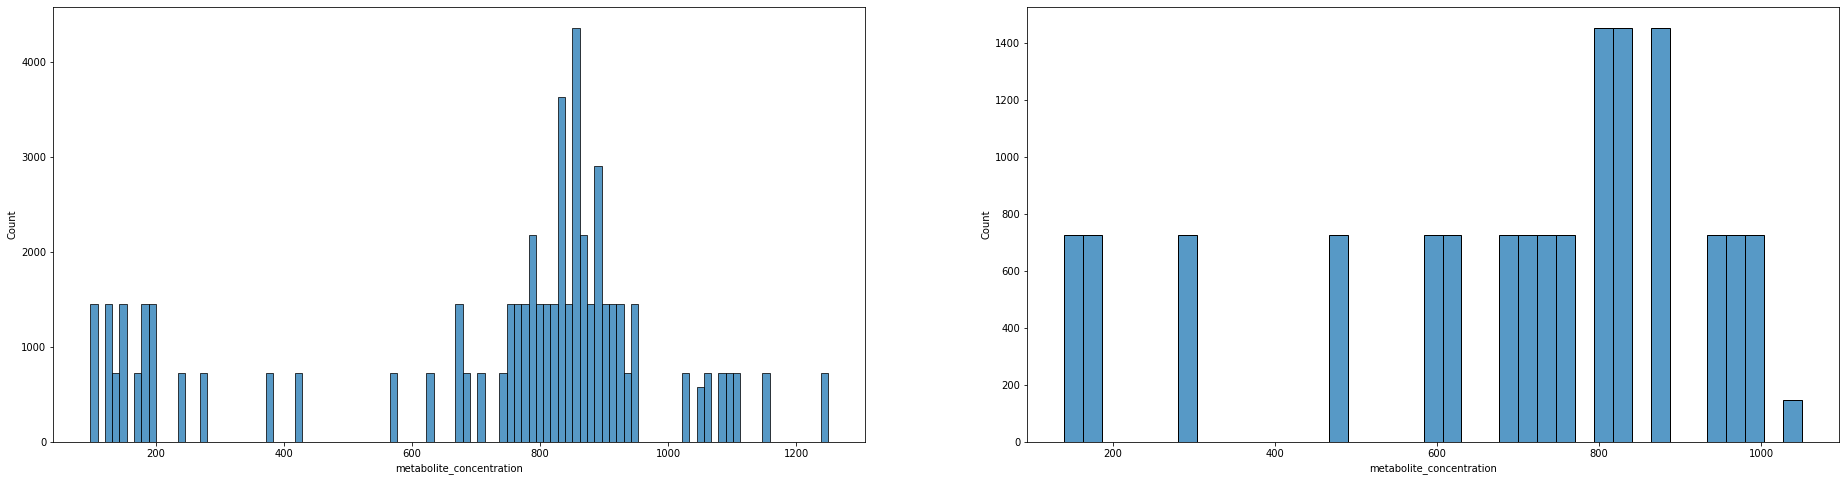

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 8))
sns.histplot(y_train, ax=ax1)
sns.histplot(y_test, ax=ax2)

In [ ]:
clf['regressor'].regressor

DecisionTreeRegressor()

In [ ]:
fig, ax = plt.subplots(figsize=(64, 64))
plot_tree(
    model.regressor.named_steps['regressor']
)

In [ ]:
transform = make_column_transformer(
    (OneHotEncoder(), ['KO_ORF', 'ORF'])
)

In [ ]:

df = transform.fit_transform(df)



In [ ]:
X_train

,KO_ORF,ORF,enzyme_concentration
36254,YJL165C,YPL028W,7.928044
28857,YHR135C,YMR116C,9.429324
58631,YOL113W,YMR203W,5.563761
38196,YJR066W,YKR074W,5.023174
45294,YLL019C,YGR180C,7.942237
...,...,...,...
21243,YGL179C,YER003C,7.177314
45891,YLR096W,YDR304C,6.456569
42613,YKL166C,YLR429W,5.862710
43567,YKL171W,YAL044C,7.113592


In [ ]:
dt = DecisionTreeRegressor()

dt.fit(X_train, y_train)
dt.score(X_test, y_test)

mean_squared_error(y_test, dt.predict(X_test))

ValueError: could not convert string to float: 'YJL165C'

In [ ]:
svr = SVR()
svr.score(X_test, y_test)

In [ ]:
mean_squared_error(y_test, svr.predict(X_test))